# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_32', 'ORACLE.run2_8', 'ORACLE.run2_50', 'ORACLE.run2_14', 'ORACLE.run2_38', 'ORACLE.run2_44', 'ORACLE.run2_20', 'ORACLE.run2_26'}


{'ORACLE.run1_32', 'ORACLE.run1_14', 'ORACLE.run1_8', 'ORACLE.run1_26', 'ORACLE.run1_20', 'ORACLE.run1_38', 'ORACLE.run1_44', 'ORACLE.run1_50'}


tensor([[[ 0.9116,  0.4428, -1.1287,  ..., -0.2691,  1.2329, -0.5383],
         [-0.0521,  0.7467, -0.0695,  ..., -0.9464, -0.9290, -1.0592]],

        [[-0.4053,  0.5639,  0.5639,  ..., -0.9340, -1.3129, -0.5639],
         [-0.8811, -0.7401,  1.0662,  ...,  0.5287, -0.4670,  1.2776]],

        [[-0.5051, -0.7315,  0.2874,  ...,  1.0537,  0.9666,  1.1059],
         [ 1.1320, -0.0697, -1.2975,  ...,  0.3657,  0.8708, -0.9056]],

        ...,

        [[-1.3267, -0.0918,  1.2850,  ...,  0.0000, -0.1418,  1.3017],
         [ 0.1418, -0.7426, -0.2837,  ...,  1.0347,  1.0513,  0.1001]],

        [[ 0.5750, -0.2464, -0.6161,  ...,  0.0246,  1.3308,  0.9693],
         [ 0.1479,  1.1254, -0.5175,  ..., -1.1090,  0.4190, -0.2464]],

        [[-0.6472, -1.0159,  0.9668,  ...,  0.9258, -0.6472,  0.7292],
         [ 0.3113, -0.4506, -0.6063,  ...,  0.4506,  1.2289,  0.7619]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.3724, train_label_loss: 2.7891, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2270.6790, train_label_loss: 1.4042, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2324.7040, train_label_loss: 1.3028, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2600.0119, train_label_loss: 0.3716, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2618.0719, train_label_loss: 0.6888, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2561.0631, train_label_loss: 0.6022, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2313.9030, train_label_loss: 0.3586, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2524.2374, train_label_loss: 0.9976, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2550.0335, train_label_loss: 0.7913, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2568.9560, train_label_loss: 0.3141, 


epoch: 1, source_val_acc_label: 0.7677, target_val_acc_label: 0.7772, source_val_label_loss: 6.0224, target_val_label_loss: 4.2676, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.3005, train_label_loss: 1.0200, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2812.0131, train_label_loss: 0.8287, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3218.2873, train_label_loss: 0.8531, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2570.5348, train_label_loss: 0.2700, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2599.4133, train_label_loss: 0.6502, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2310.1791, train_label_loss: 0.4350, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2321.1971, train_label_loss: 0.4160, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2308.8493, train_label_loss: 0.5519, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2348.1600, train_label_loss: 0.2329, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2326.1336, train_label_loss: 0.3495, 


epoch: 2, source_val_acc_label: 0.8257, target_val_acc_label: 0.8280, source_val_label_loss: 0.4971, target_val_label_loss: 0.4761, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.0138, train_label_loss: 0.1501, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2466.5852, train_label_loss: 0.4180, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2685.9340, train_label_loss: 0.4354, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2638.9631, train_label_loss: 0.4171, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2415.8351, train_label_loss: 0.6459, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2317.2085, train_label_loss: 0.2866, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2317.3642, train_label_loss: 0.5504, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2307.6815, train_label_loss: 0.4819, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2337.4993, train_label_loss: 0.2893, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2317.5652, train_label_loss: 0.3372, 


epoch: 3, source_val_acc_label: 0.8403, target_val_acc_label: 0.8361, source_val_label_loss: 0.4540, target_val_label_loss: 0.4434, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.0107, train_label_loss: 0.5564, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2626.8429, train_label_loss: 0.2479, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2886.3899, train_label_loss: 0.2576, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2979.5511, train_label_loss: 0.1552, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2935.9793, train_label_loss: 0.2429, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2931.9413, train_label_loss: 0.3313, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2917.7982, train_label_loss: 0.5860, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2972.5666, train_label_loss: 0.5845, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3065.4996, train_label_loss: 0.3137, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3257.7249, train_label_loss: 0.4611, 


epoch: 4, source_val_acc_label: 0.8642, target_val_acc_label: 0.8583, source_val_label_loss: 0.3880, target_val_label_loss: 0.3958, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.6657, train_label_loss: 0.5356, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2985.6338, train_label_loss: 0.1783, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2975.2951, train_label_loss: 0.5399, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2992.6849, train_label_loss: 0.1145, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2981.5922, train_label_loss: 0.1103, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2952.8294, train_label_loss: 0.2961, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2974.5755, train_label_loss: 0.0927, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2949.7834, train_label_loss: 0.3205, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2540.7244, train_label_loss: 0.1097, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2311.3340, train_label_loss: 0.1477, 


epoch: 5, source_val_acc_label: 0.8884, target_val_acc_label: 0.8776, source_val_label_loss: 0.3159, target_val_label_loss: 0.3472, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 1.9975, train_label_loss: 0.2804, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2284.2380, train_label_loss: 0.2225, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2597.9841, train_label_loss: 0.2752, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2558.3869, train_label_loss: 0.2074, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2573.6480, train_label_loss: 0.1095, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2876.0160, train_label_loss: 0.2763, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2910.1318, train_label_loss: 0.2540, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2987.2730, train_label_loss: 0.2540, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2601.8724, train_label_loss: 0.1155, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2883.6778, train_label_loss: 0.2390, 


epoch: 6, source_val_acc_label: 0.8724, target_val_acc_label: 0.8624, source_val_label_loss: 0.3512, target_val_label_loss: 0.3842, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.0834, train_label_loss: 0.3754, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2341.0181, train_label_loss: 0.2667, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2320.2442, train_label_loss: 0.2622, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2315.5919, train_label_loss: 0.4213, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2486.2837, train_label_loss: 0.4174, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2567.7557, train_label_loss: 0.4097, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2657.9960, train_label_loss: 0.3063, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2338.9444, train_label_loss: 0.2574, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2321.5662, train_label_loss: 0.4254, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2318.2317, train_label_loss: 0.3139, 


epoch: 7, source_val_acc_label: 0.8812, target_val_acc_label: 0.8687, source_val_label_loss: 0.3280, target_val_label_loss: 0.3686, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.0082, train_label_loss: 0.3596, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2333.4054, train_label_loss: 0.0645, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2319.1753, train_label_loss: 0.1130, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2430.0947, train_label_loss: 0.1089, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2594.6279, train_label_loss: 0.1506, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2685.8158, train_label_loss: 0.1990, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2382.7258, train_label_loss: 0.1257, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2303.4133, train_label_loss: 0.3307, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2324.2737, train_label_loss: 0.4237, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2309.5612, train_label_loss: 0.4792, 


epoch: 8, source_val_acc_label: 0.8972, target_val_acc_label: 0.8823, source_val_label_loss: 0.2897, target_val_label_loss: 0.3421, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.2787, train_label_loss: 0.2210, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2698.3229, train_label_loss: 0.0430, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2611.1567, train_label_loss: 0.4408, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3038.7412, train_label_loss: 0.1150, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3042.9141, train_label_loss: 0.0983, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3266.4508, train_label_loss: 0.2330, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2444.9955, train_label_loss: 0.1055, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2324.7297, train_label_loss: 0.0334, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2332.4479, train_label_loss: 0.1366, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2341.3187, train_label_loss: 0.2202, 


epoch: 9, source_val_acc_label: 0.8935, target_val_acc_label: 0.8790, source_val_label_loss: 0.2992, target_val_label_loss: 0.3466, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.0227, train_label_loss: 0.3006, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2327.2645, train_label_loss: 0.4472, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2537.8277, train_label_loss: 0.2011, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2586.9425, train_label_loss: 0.2338, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2641.6064, train_label_loss: 0.1545, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2316.6299, train_label_loss: 0.1854, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2309.5053, train_label_loss: 0.2772, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2291.4013, train_label_loss: 0.2585, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2332.0353, train_label_loss: 0.0569, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2428.5904, train_label_loss: 0.0310, 


epoch: 10, source_val_acc_label: 0.8824, target_val_acc_label: 0.8674, source_val_label_loss: 0.3193, target_val_label_loss: 0.3707, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.3035, train_label_loss: 0.0330, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2724.8245, train_label_loss: 0.1083, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3037.9599, train_label_loss: 0.3466, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2960.9178, train_label_loss: 0.1132, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3032.4146, train_label_loss: 0.3720, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2575.4458, train_label_loss: 0.2113, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2338.5435, train_label_loss: 0.6326, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2332.7330, train_label_loss: 0.1605, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2313.4531, train_label_loss: 0.2303, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2352.4218, train_label_loss: 0.0528, 


epoch: 11, source_val_acc_label: 0.8954, target_val_acc_label: 0.8844, source_val_label_loss: 0.3089, target_val_label_loss: 0.3408, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.0130, train_label_loss: 0.3751, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2646.7246, train_label_loss: 0.0657, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2632.6499, train_label_loss: 0.4552, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2555.4079, train_label_loss: 0.0365, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2298.5426, train_label_loss: 0.0575, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2320.1694, train_label_loss: 0.1195, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2307.2902, train_label_loss: 0.1711, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2282.9230, train_label_loss: 0.1751, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2305.3278, train_label_loss: 0.0308, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2323.8700, train_label_loss: 0.2205, 


epoch: 12, source_val_acc_label: 0.8876, target_val_acc_label: 0.8724, source_val_label_loss: 0.3338, target_val_label_loss: 0.3752, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.0775, train_label_loss: 0.3324, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2642.0117, train_label_loss: 0.2408, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2631.2225, train_label_loss: 0.0211, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2324.0115, train_label_loss: 0.0800, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2307.1254, train_label_loss: 0.1131, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2444.6609, train_label_loss: 0.0767, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2590.4924, train_label_loss: 0.3785, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2622.3739, train_label_loss: 0.2866, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2612.7113, train_label_loss: 0.3839, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2568.8696, train_label_loss: 0.1012, 


epoch: 13, source_val_acc_label: 0.9030, target_val_acc_label: 0.8877, source_val_label_loss: 0.3171, target_val_label_loss: 0.3338, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.5104, train_label_loss: 0.0174, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3322.0432, train_label_loss: 0.2431, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2596.8941, train_label_loss: 0.1904, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2622.0392, train_label_loss: 0.0430, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2608.7791, train_label_loss: 0.2936, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2563.5996, train_label_loss: 0.0787, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2618.1820, train_label_loss: 0.1305, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2574.4084, train_label_loss: 0.1866, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2591.4691, train_label_loss: 0.2046, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2595.3251, train_label_loss: 0.1198, 


epoch: 14, source_val_acc_label: 0.9056, target_val_acc_label: 0.8864, source_val_label_loss: 0.2654, target_val_label_loss: 0.3463, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.7206, train_label_loss: 0.1538, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2997.5851, train_label_loss: 0.2390, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2998.2872, train_label_loss: 0.2467, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2936.0943, train_label_loss: 0.0723, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3085.5635, train_label_loss: 0.2646, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3371.9968, train_label_loss: 0.2798, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3332.1385, train_label_loss: 0.1380, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3152.2520, train_label_loss: 0.2447, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2571.9382, train_label_loss: 0.1881, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2537.7174, train_label_loss: 0.1539, 


epoch: 15, source_val_acc_label: 0.9022, target_val_acc_label: 0.8840, source_val_label_loss: 0.2793, target_val_label_loss: 0.3526, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.5573, train_label_loss: 0.3092, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2347.3409, train_label_loss: 0.0922, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2335.9324, train_label_loss: 0.1098, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2331.3905, train_label_loss: 0.4055, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2311.3477, train_label_loss: 0.0863, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2468.8334, train_label_loss: 0.2363, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2571.3903, train_label_loss: 0.1774, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2672.7945, train_label_loss: 0.0225, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2324.3877, train_label_loss: 0.0741, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2309.0805, train_label_loss: 0.6624, 


epoch: 16, source_val_acc_label: 0.9036, target_val_acc_label: 0.8860, source_val_label_loss: 0.2732, target_val_label_loss: 0.3394, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.0210, train_label_loss: 0.0129, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2342.4339, train_label_loss: 0.0376, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2337.9266, train_label_loss: 0.1400, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2325.7719, train_label_loss: 0.1790, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2336.0148, train_label_loss: 0.1443, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2517.2859, train_label_loss: 0.4416, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2655.9786, train_label_loss: 0.1191, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2736.6711, train_label_loss: 0.1176, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2334.0428, train_label_loss: 0.0956, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2331.9803, train_label_loss: 0.1902, 


epoch: 17, source_val_acc_label: 0.9022, target_val_acc_label: 0.8831, source_val_label_loss: 0.2857, target_val_label_loss: 0.3565, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

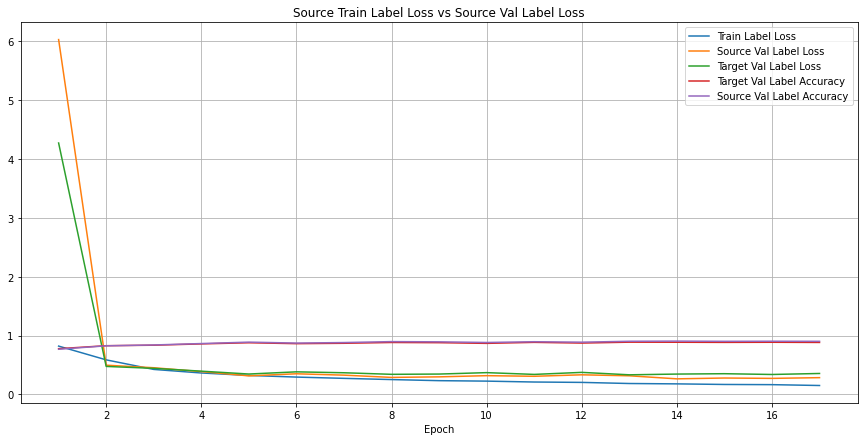

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

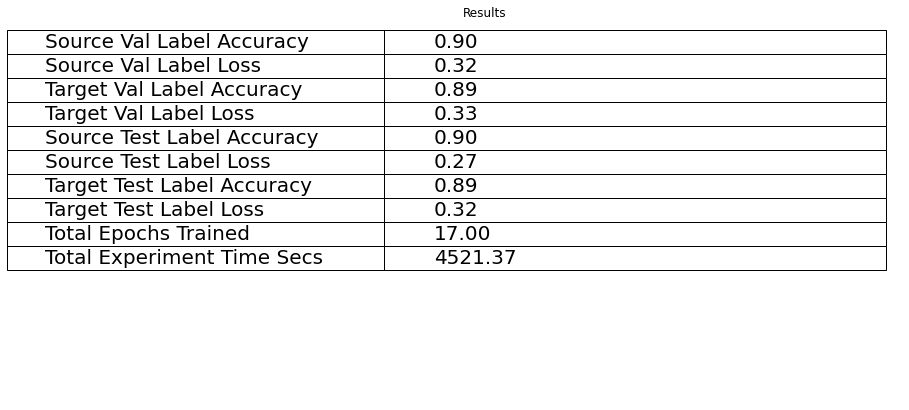

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

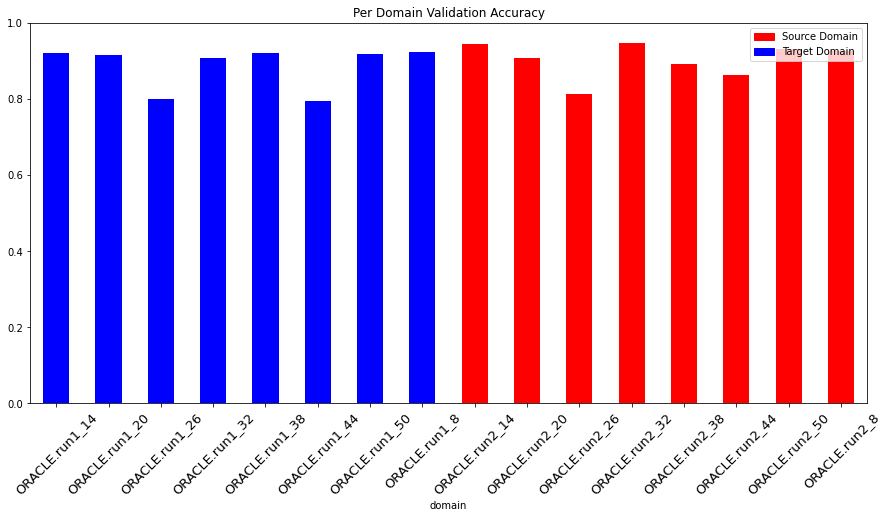

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9029622395833333 Target Test Label Accuracy: 0.8883138020833333
Source Val Label Accuracy: 0.90302734375 Target Val Label Accuracy: 0.8876953125


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048